In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from matplotlib.patches import Wedge
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
# import VS model
import sys
sys.path.insert(0, '../boris-tracing/')
from efields import *
from plottools import *

In [3]:
def mag(vec):

    magnitude = np.sqrt(np.dot(vec, vec))
    return magnitude


# Background

### Corotation Fields
The corotation electric field is related tot he rotation of Earth along its spin axis. The **corotation electric field** is
$$\mathbf{E_{cr}}=-\nabla\left(\phi_{cr}\right)$$
$$\mathbf{E_{cr}}= \begin{equation}
\frac{-\omega_E R_E B_E}{r^2 / R_E^2}
\end{equation} \tag{}$$

With potential
$$\phi_{cr} = \begin{equation}\frac{-\omega_E R_E^2 B_E}{r / R_E} = \frac{-92 \text{kV}}{r/R_E}
\end{equation} \tag{}$$
Here, $\omega_E$ is the angular velocity of the Earth’s rotation and $B_E$ is the equatorial magnetic field strength at surface of Earth.

### Convection Fields: Volland-Stern
Volland (1973) and Stern (1975) define a convection electric field model of the magnetosphere as the negative gradient of the potential $\phi_{c}$ and corotation potential $\phi_{cr}$:

$$\mathbf{E_c}=-\nabla\left(\phi_{c}\right) \tag{[Stern (1975)] 1}$$

Where the **Volland-Stern potential** is defined as
$$\phi_{c}=-A_{0} r^{\gamma} \sin \psi \tag{[Ferradas (2017)] 1.16}$$
Where the magnetic local time ($\psi$) is related to azimuth by $\psi = \phi/24$, and the  uniform convection electric field strength in the equatorial plane $A_0$ is
$$A_{0}=\frac{0.045}{\left(1-0.159 K p+0.0093 K p^{2}\right)^{3}} \frac{k V}{R_{E}^{2}}$$

By Taking the inverse gradient of this potential, we derive the **Volland-Stern magnetospheric convection electric field**
$$\mathbf{E_c} = A_0 \left (\gamma r^{\gamma-1}\sin (\phi) \hat{\mathbf{r}} +  0\hat{\boldsymbol{\theta}} + \frac{r^{\gamma-1}}{\sin\theta}\cos (\phi) \hat{\boldsymbol{\phi}} \right )$$

#### Total Electric Field
From the convection and corotation electric field, the total electric field is, 
$$\begin{equation}
\mathbf{E}=-\nabla\left(\phi_c+\phi_{cr}\right)
\end{equation} \tag{[Stern 1975] 4}$$

# Calculations
Calculate grid of potential and electric field values.

In [4]:
'''
constants
'''
kp      = 6.5       # kp index
gs      = 2.0       # shielding constant
RE      = 6371000   # radius of earth [m] 
lmax    = 10        # max L-shell level (L) to be calculated
mltmax  = 24        # max magnetic local time (MLT)

# convert to radial geo and theta

rmax = lmax*RE                  # rdist(lmax, mltmax)
pmax = mltmax*15*(np.pi/180)    # max angle
dr   = 300                      # number of gridpoints




In [5]:
# create coordinate grids

rn = np.linspace(RE, rmax, dr)
pn = np.linspace(0., pmax, dr)

r, phi = np.meshgrid(rn, pn)


ln = np.linspace(0, lmax, dr)
mn = np.linspace(0.0, mltmax, dr)

l, mlt = np.meshgrid(ln, mn)


# arrays to hold data

emap_new = np.zeros(r.shape)   # convection E-field 
umap_new = np.zeros(r.shape)   # potential 
etot_new = np.zeros(r.shape)   # total E-field (convection and corotation)
utot_new = np.zeros(r.shape)   # total potential (convection and corotation)

# compute field values
for i in range(0,dr):
    for j in range(0,dr):
        
        r0 = r[i,j]
        p0 = phi[i,j]
        coords = np.array([r0, np.pi/2., p0])
        
        # calculations

        EC = vs_efield(coords, gs, kp, sph = True)      # convection E-field [mV/m]
        ER = corotation_efield(coords, sph = True)      # corotation E-field [mV/m]
        UC = vs_potential(coords, gs, kp, sph = True)   # convection potential [kV]
        UR = corotation_potential(coords, sph = True)   # corotation potential [kV]
        

        emap_new[i,j] = mag(EC)
        umap_new[i,j] = UC
        etot_new[i,j] = mag(EC+ER)
        utot_new[i,j] = UC+UR
        
        # test
        # print(UR, utot_new[i,j])
        # print(f"(i,j): ({i},{j}) | coords: {round(r0,2)} | UC: {round(UC,2)} | UR: {round(UR,2)} | SUM: {UR+UC} | utot = {utot_new[i,j]} ")


# remove unwanted datapoints within 1RE, where Earth is
bad = np.where(r < RE)
emap_new[bad] = np.nan

# Plots and Figures

### Additional functions for plotting

In [6]:

# colorscales for color consistency 
pcolor = 'GnBu'
# colorscale for sequential plots
cseq = 'YlGnBu'
# colorscale for divergent plots (negative and positive values)
cdiv = 'RdGy'

                     
def center_axis(ax):
    """
    Set axis at origin.
    """
    # move left y-axis and bottim x-axis to origin
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # remove extra axis
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # select axis tick locations
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    # minor ticks
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    
    # tick styling
    for axi in ['x','y']:   
        ax.tick_params(axis=axi, length=6, which="major", direction="inout")
        ax.tick_params(axis=axi, length=4, which="minor", direction="inout")
    
    # endcaps on axis (source: Stack Overflow question 33737736)
    ax.plot((1), (0), marker="|", ms=11, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot((0), (1), marker="_", ms=11, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot((0), (0), marker="|", ms=11, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot((0), (0), marker="_", ms=11, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
    
    
'''
Calculate last closed equipotential (LCE)

From Matsui et al.:
In order to calculate such contours, we first search for maximum potential 
in the radial direction at a fixed MLT value, and then get the minimum of 
these maximum potentials in the whole MLT range.
'''

def get_LCE(phidat, udat):

    # list to hold maximum potential at every MLT
    umax = []
    
    # find all coordinate locations at a fixed phi/MLT value, phi[N]
    for i in range(0, dr):
        
        phi_loc = np.where(phidat==pn[i])
        
        uvals = [] 
        
        for j in range(0, dr):
            
            # find locations where phi[N] exists
            c1 = phi_loc[0][j]
            c2 = phi_loc[1][j]
            
            # find all potential values at phi[N]
            uvals.append(udat[c1][c2])
            
        # find maximum potential 
        umax.append(max(uvals))
        
    # compute minimum of max potentials in the whole MLT range
    LCE = min(umax)
    return LCE
        

    


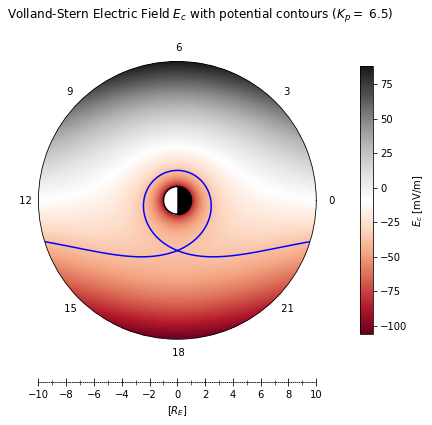

In [7]:
'''
plot of volland-stern convection electric and potential
'''
# scale coordinates in units [RE] 
rscale = r/RE

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, subplot_kw=dict(projection='polar'), figsize=(6, 6))
ax1 = axes[0, 0]
ax1.grid(False)


# A/N: standard figsize, use y=1.05 in 'suptitle' and no fraction in 'colorbar'

# plot E-field
uplot = ax1.pcolormesh(phi, rscale, utot_new, cmap=cdiv, shading='nearest')
fig.colorbar(uplot, ax=ax1, pad=0.13, fraction=0.04, label="$E_c$ [mV/m]")


# scale angular by MLT
scale_ang = ticker.FuncFormatter(lambda phi, pos: '{0: .0f}'.format(math.degrees(phi/15)))
ax1.xaxis.set_major_formatter(scale_ang)

# hide radial labels
ax1.set_yticklabels([])

# RE-scaled subaxis 
add_offscale_RE(ax1, 10, half=False)

# set title
fig.suptitle(f"Volland-Stern Electric Field $E_c$ with potential contours ($K_p =$ {kp})", y = 0.95)

# draw the earth
draw_earth(ax1, polar=True, style=False, zorder=10)

# compute and plot LCE
# compute and plot LCE
LCE = get_LCE(phi, utot_new)
LCE_plot = ax1.contour(phi, rscale, utot_new, [LCE], colors='b', linestyles='solid') 

plt.show()

# save figure
# fname = 'plot_VS_efield_full'
#plt.savefig('../bin/'+fname+'.png',bbox_inches='tight', dpi=150)



### Figure 1a: Volland-Stern Potential

Text(0.5, 0.95, 'Volland-Stern Potential ($K_p =$ 6.5)')

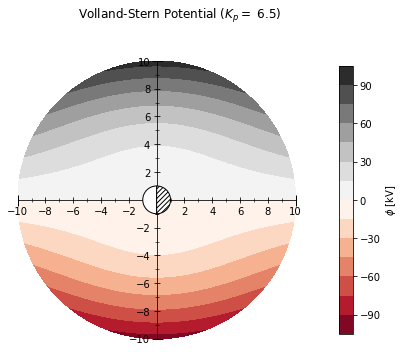

In [8]:
'''
plot of volland-stern convection potential
'''
# scale coordinates in units [RE] 
rscale = r/RE

def sph_to_crt(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

x, y = sph_to_crt(rscale,phi)

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(6,6))
ax1 = axes[0, 0]

# plot convection potential
uplot = ax1.contourf(x, y, umap_new, levels = 12, cmap=cdiv)
fig.colorbar(uplot, ax=ax1, pad=0.13, fraction=0.04, label="$\phi$ [kV]")

# axis adjustment
ax1.set_aspect('equal')

# set center axis
center_axis(ax1)

# tick frequency
ticks = np.arange(-lmax,lmax+1,2)
plt.xticks(ticks)
plt.yticks(ticks)

# draw earth 
draw_earth(ax1,1,style=True, zorder=3)

# set title
fig.suptitle(f"Volland-Stern Potential ($K_p =$ {kp})", y = 0.95)



### Figure 1b: Total Potential
Volland-Stern and corotation potential

/tmp/ipykernel_10236/1994148874.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  uplot = ax1.pcolormesh(x, y, utot_new, cmap=cdiv, shading='nearest')


Text(0.5, 0.95, 'Total potential ($K_p =$ 6.5)')

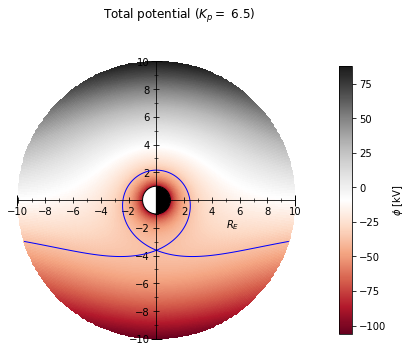

In [9]:
'''
plot of volland-stern convection potential
'''
# scale coordinates in units [RE] 
rscale = r/RE

def sph_to_crt(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

x, y = sph_to_crt(rscale,phi)

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(6,6))
ax1 = axes[0, 0]

# plot convection potential
uplot = ax1.pcolormesh(x, y, utot_new, cmap=cdiv, shading='nearest')
fig.colorbar(uplot, ax=ax1, pad=0.13, fraction=0.04, label="$\phi$ [kV]")

# axis adjustment
ax1.set_aspect('equal')

# set center axis
center_axis(ax1)

# tick frequency
ticks = np.arange(-lmax,lmax+1,2)
plt.xticks(ticks)
plt.yticks(ticks)

# minor ticks
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(1))

# axis special label
ax1.text(5,-2,'$R_E$')

# draw earth 
draw_earth(ax1,1, zorder=10)

# compute and plot LCE
LCE = get_LCE(phi, utot_new)
LCE_plot = ax1.contour(x, y, utot_new, [LCE], colors='b', linestyles='solid', linewidths=1) 

# set title
fig.suptitle(f"Total potential ($K_p =$ {kp})", y = 0.95)



### Figure 1c: Contour Total Potential

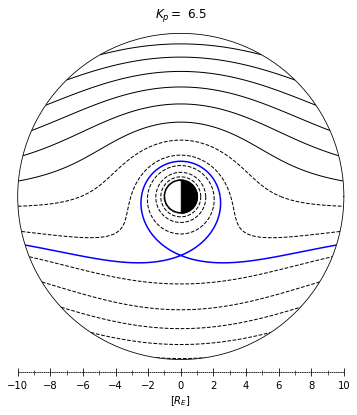

In [10]:
'''
plot of volland-stern convection electric and potential
'''

# scale coordinates in units [RE] 
rscale = r/RE

kparr = [1, 3, 6.5, 8.5]

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, subplot_kw=dict(projection='polar'), figsize=(6, 6))
ax1 = axes[0, 0]

uplot = ax1.contour(phi, rscale, utot_new, 12, colors='k', linewidths=1) 
ax1.grid(False)

# scale angular by MLT
scale_ang = ticker.FuncFormatter(lambda phi, pos: '{0: .0f}'.format(math.degrees(phi/15)))
ax1.xaxis.set_major_formatter(scale_ang)

# hide labels
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# RE-scaled subaxis 
add_offscale_RE(ax1, 10, offset=0.03)

# set title
ax1.set_title(f"$K_p =$ {kp}", y=1.03)

# draw the earth
draw_earth(ax1, polar=True, style=False, zorder=10)

# compute and plot LCE
LCE = get_LCE(phi, utot_new)
LCE_plot = ax1.contour(phi, rscale, utot_new, [LCE], colors='b', linestyles='solid') 
#LCE_plot.ax1.clabel(uplot, uplot.levels, fmt = 'LCE')


plt.show()

### Figure 2a: Volland-Stern convection electric field with potential contours.

/tmp/ipykernel_10236/2372831620.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  eplot = ax1.pcolormesh(phi, rscale, emap_new, cmap=cseq, shading='nearest')


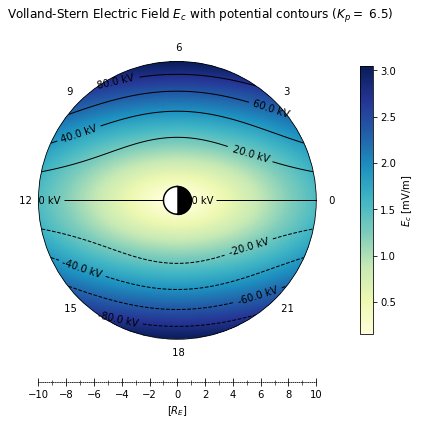

In [11]:
'''
plot of volland-stern convection electric and potential
'''
# scale coordinates in units [RE] 
rscale = r/RE

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, subplot_kw=dict(projection='polar'), figsize=(6, 6))
ax1 = axes[0, 0]
# A/N: standard figsize, use y=1.05 in 'suptitle' and no fraction in 'colorbar'

# plot E-field
eplot = ax1.pcolormesh(phi, rscale, emap_new, cmap=cseq, shading='nearest')
fig.colorbar(eplot, ax=ax1, pad=0.13, fraction=0.04, label="$E_c$ [mV/m]")

# plot potential contours
uplot = ax1.contour(phi, rscale, umap_new, 10, colors='k', linewidths=1) 
ax1.clabel(uplot, uplot.levels, fmt = '%.1f kV')

# scale angular by MLT
scale_ang = ticker.FuncFormatter(lambda phi, pos: '{0: .0f}'.format(math.degrees(phi/15)))
ax1.xaxis.set_major_formatter(scale_ang)

# hide radial labels
ax1.set_yticklabels([])

# RE-scaled subaxis 
add_offscale_RE(ax1, 10, half=False)

# set title
fig.suptitle(f"Volland-Stern Electric Field $E_c$ with potential contours ($K_p =$ {kp})", y = 0.95)

# draw the earth
draw_earth(ax1, polar=True, style=False, zorder=10)

plt.show()

# save figure
# fname = 'plot_VS_efield_full'
#plt.savefig('../bin/'+fname+'.png',bbox_inches='tight', dpi=150)

In [12]:
'''
other ways to adjust plot - save for later
'''
# set clockwise labels
# ax1.set_theta_direction(-1)

# scale radial axis by RE (L-shell) - only if not plotting with rscale
#scale_rad = ticker.FuncFormatter(lambda r, pos: '{0:.0f}'.format(r/RE))
#ax1.yaxis.set_major_formatter(scale_rad)

# place 0 at top
#ax1.set_theta_zero_location('N')  
#ax1.set_theta_offset(np.pi/2.0) 

# adjust angle of radial axis labels  - only if not plotting with rscale
# ax1.set_rlabel_position(0) 

#fig.suptitle(f"Volland-Stern Electric Field $E_c$ ($K_p =$ {kp})", y = 1.05)
#fig.colorbar(fig1, ax=ax1)



'\nother ways to adjust plot - save for later\n'

### Figure 2b: Total Electric Field

/tmp/ipykernel_10236/1939268456.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  eplot = ax1.pcolormesh(phi, rscale, etot_new, cmap='YlGnBu_r', shading='nearest')


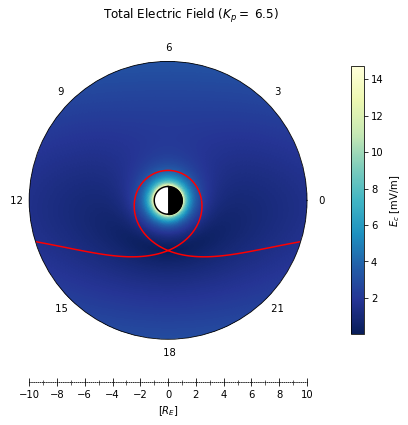

In [13]:
'''
plot of volland-stern convection electric and potential
'''
# scale coordinates in units [RE] 
rscale = r/RE

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, subplot_kw=dict(projection='polar'), figsize=(6, 6))
ax1 = axes[0, 0]
# A/N: standard figsize, use y=1.05 in 'suptitle' and no fraction in 'colorbar'

# plot E-field
eplot = ax1.pcolormesh(phi, rscale, etot_new, cmap='YlGnBu_r', shading='nearest')
fig.colorbar(eplot, ax=ax1, pad=0.13, fraction=0.04, label="$E_c$ [mV/m]")

# scale angular by MLT
scale_ang = ticker.FuncFormatter(lambda phi, pos: '{0: .0f}'.format(math.degrees(phi/15)))
ax1.xaxis.set_major_formatter(scale_ang)

# hide radial labels and add RE-scaled subaxis 
ax1.set_yticklabels([])
add_offscale_RE(ax1,10)

# set title
fig.suptitle(f"Total Electric Field ($K_p =$ {kp})", y = 0.95)

# draw the earth
draw_earth(ax1, polar=True, zorder=10)

# compute and plot LCE
LCE = get_LCE(phi, utot_new)
LCE_plot = ax1.contour(phi, rscale, utot_new, [LCE], colors='r', linestyles='solid') 

plt.show()

# Refrences
* Volland, H. 1973. “A semiempirical model of large-scale magnetospheric electric fields.”Journal of Geophysical
Research.https://doi.org/10.1029/JA078i001p00171.
* Stern, D. 1975. The motion of a proton in the equatorial magnetosphere. Journal of Geophysical
Research.https://doi.org/10.1029/JA080i004p00595.
* Maynard, N. C., and Chen, A. J. "Isolated cold plasma regions: Observations and their relation to possible production mechanisms" Journal of Geophysical
Research. https://doi.org/10.1029/JA080i007p01009
* Ferradas, C. (2017). <i>Understanding Ion Spectral Dynamics Near the Inner Edge Of The Plasma Sheet. https://scholars.unh.edu/dissertation